## 0. Imports

In [63]:
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torchmetrics.classification import BinaryAccuracy
from tqdm.notebook import tqdm

## 1. Data preparation and cleaning

### Load dataset

In [64]:
df = pd.read_excel('movies.xlsx')
pd.set_option('display.max_columns', None)

# Truncate
pd.set_option('display.max_rows', False)

# Dont truncate
# pd.set_option('display.max_rows', None)

### Dataset info

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1402 entries, 0 to 1401
Data columns (total 31 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Film                                     1402 non-null   object 
 1   Year                                     1402 non-null   int64  
 2   Script Type                              1402 non-null   object 
 3   Rotten Tomatoes  critics                 1401 non-null   object 
 4   Metacritic  critics                      1402 non-null   object 
 5   Average critics                          1402 non-null   object 
 6   Rotten Tomatoes Audience                 1401 non-null   float64
 7   Metacritic Audience                      1402 non-null   object 
 8   Rotten Tomatoes vs Metacritic  deviance  1402 non-null   object 
 9   Average audience                         1402 non-null   object 
 10  Audience vs Critics deviance             1402 no

In [66]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,1402.0,2012.140514,3.190291,2007.0,2009.0000,2012.000,2015.0000,2017.00
Rotten Tomatoes Audience,1401.0,62.122769,17.435737,17.0,49.0000,62.000,76.0000,98.00
Opening weekend ($million),1402.0,23.200357,28.547541,0.0,6.6025,14.200,28.5975,247.97
Domestic gross ($million),1402.0,74.058024,87.389737,0.0,21.0900,44.045,92.5900,936.66
Worldwide Gross ($million),1402.0,173.008302,233.859025,0.0,38.0000,88.690,208.7500,2781.50
Distributor,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IMDb Rating,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IMDB vs RT disparity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
df.describe(include='object').T

,count,unique,top,freq
Film,1402,1396,Big Miracle,2
Script Type,1402,17,original screenplay,546
Rotten Tomatoes critics,1401,102,93,29
Metacritic critics,1402,90,51,39
Average critics,1402,196,64,25
Metacritic Audience,1402,78,66,50
Rotten Tomatoes vs Metacritic deviance,1402,82,-1,58
Average audience,1402,116,58,45
Audience vs Critics deviance,1402,78,-5,54
...,...,...,...,...


### Drop empty, unecessary and extraneous columns for classification

In [68]:
df = df.drop(['Distributor', 'IMDb Rating', 'IMDB vs RT disparity', 'Opening Weekend', 'Domestic Gross', 'Foreign Gross', 'Worldwide Gross', 'Film', 'Year', 'Release Date (US)', 'Oscar Detail', 'Rotten Tomatoes vs Metacritic  deviance', 'Audience vs Critics deviance ', 'Worldwide Gross ($million)', ' of Gross earned abroad', 'Average audience ', 'Average critics ', ' Budget recovered', ' Budget recovered opening weekend'], axis=1)

### Handle missing values

In [69]:
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

In [70]:
print('Missing data\n--------------')
print(missing_data)


Missing data
--------------
Script Type                      0
Rotten Tomatoes  critics         1
Metacritic  critics              0
Rotten Tomatoes Audience         1
Metacritic Audience              0
Primary Genre                 1383
Genre                            1
Opening weekend ($million)       0
Domestic gross ($million)        0
Foreign Gross ($million)         0
Budget ($million)                0
Oscar Winners                 1346
dtype: int64


In [71]:
print('Missing data percentages\n--------------')
print(missing_percentage)

Missing data percentages
--------------
Rotten Tomatoes  critics      0.071327
Rotten Tomatoes Audience      0.071327
Primary Genre                98.644793
Genre                         0.071327
Oscar Winners                96.005706
dtype: float64


In [72]:
df = df.dropna(subset=['Genre', 'Rotten Tomatoes  critics', 'Rotten Tomatoes Audience '])

In [73]:
# Drop invalid lines
df = df[~df.isin(['-']).any(axis=1)]
# df[(df == '-').any(axis=1)]

In [74]:
missing_data = df.isnull().sum()
missing_data

Script Type                      0
Rotten Tomatoes  critics         0
Metacritic  critics              0
Rotten Tomatoes Audience         0
Metacritic Audience              0
Primary Genre                 1372
Genre                            0
Opening weekend ($million)       0
Domestic gross ($million)        0
Foreign Gross ($million)         0
Budget ($million)                0
Oscar Winners                 1335
dtype: int64

### Check for dublicates

In [75]:
df.duplicated(keep=False).sum()

0

In [76]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rotten Tomatoes Audience,1391.0,62.048167,17.428369,17.0,49.000,62.00,76.000,98.00
Opening weekend ($million),1391.0,23.327541,28.607251,0.0,6.755,14.30,28.720,247.97
Domestic gross ($million),1391.0,74.500093,87.569797,0.0,21.440,44.34,93.455,936.66


### Convert `script type` and `genre` to categorical values

In [77]:
df['Script Type'] = df['Script Type'].str.lower()

In [78]:
script_types = df['Script Type'].unique()

In [79]:
# Split strings and remove trailing spaces
types = []
for str in script_types:
    types.append(re.split(' / |, ',str))
script_types = [j.strip() for sub in types for j in sub]
#Convert to set to remove dublicates
script_types = set(script_types)

In [80]:
# Insert columns for each coresponding script type
for i, item in enumerate(script_types):
    df.insert(i+1, 'st_'+item, 0)

In [81]:
# Assign 1 to each corresponding script type
for i in df.index:
    for script in script_types:
        if script in df.at[i, 'Script Type']:
            df.at[i, 'st_'+script] = 1

In [82]:
df = df.drop(['Script Type'], axis=1)

In [83]:
df = df.drop(['Primary Genre'], axis=1)

In [84]:
# Convert genres to lower to avoid possible dublication
df['Genre'] = df['Genre'].str.lower()
genres = df['Genre'].unique()

In [85]:
# Split strings and remove trailing spaces
unique_genres = []
for str in genres:
    unique_genres.append(re.split(', |. ',str))
genre_types = [j.strip() for sub in unique_genres for j in sub]

#Convert to set to remove dublicates
genre_types = set(genre_types)

In [86]:
# Remove invalid values
genre_types.remove('')
genre_types.remove('adventur')
genre_types.remove('biograph')
genre_types.remove('comed')
genre_types.remove('crim')
genre_types.remove('documentar')
genre_types.remove('dram')
genre_types.remove('famiily')
genre_types.remove('famil')
genre_types.remove('fantas')
genre_types.remove('horro')
genre_types.remove('musi')
genre_types.remove('music')
genre_types.remove('myster')
genre_types.remove('romanti')
genre_types.remove('sci-f')
genre_types.remove('sport')
genre_types.remove('thriler')
genre_types.remove('thrille')

In [87]:
genre_types

{'action',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'history',
 'horror',
 'musical',
 'mystery',
 'period',
 'romance',
 'sci-fi',
 'sports',
 'thriller',
 'war',
 'western'}

In [88]:
# Insert columns for each coresponding script type
for i, item in enumerate(genre_types):
    df.insert(i+8, 'gen_'+item, 0)

In [89]:
# Assign 1 to each corresponding script type
for i in df.index:
    for genre in genre_types:
        if genre in df.at[i, 'Genre']:
            df.at[i, 'gen_'+genre] = 1

In [90]:
df = df.drop(['Genre'], axis=1)

### Convert `Oscar Winners` to gategorical numerical values

In [91]:
df['Oscar Winners'] = df["Oscar Winners"].notnull().astype("int")

### Fix decimal points

In [92]:
df = df.replace(',','', regex=True)
# df = df.astype('float32')

### Correlation map

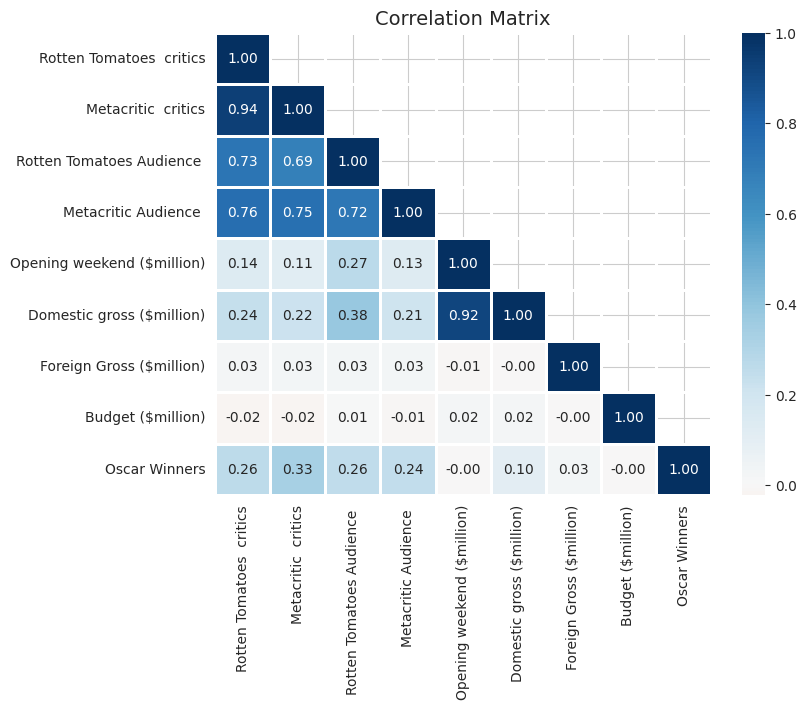

In [94]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = df.drop(columns=['st_documentary',
 'st_original screenplay',
 'st_remake',
 'st_reboot',
 'st_prequel',
 'st_adaptation',
 'st_based on a true story',
 'st_sequel',
 'gen_musical',
 'gen_biography',
 'gen_documentary',
 'gen_animation',
 'gen_thriller',
 'gen_sports',
 'gen_comedy',
 'gen_action',
 'gen_sci-fi',
 'gen_period',
 'gen_mystery',
 'gen_horror',
 'gen_history',
 'gen_crime',
 'gen_romance',
 'gen_family',
 'gen_adventure',
 'gen_drama',
 'gen_western',
 'gen_war',
 'gen_fantasy',]).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()


### Balance Classes

In [1519]:
df_oscar_winners = df[df['Oscar Winners'] == 1]

In [1520]:
df_no_oscar_winners = df[df['Oscar Winners'] != 1]
df_no_oscar_winners = df_no_oscar_winners.sample(56)

In [1521]:
frames = [df_oscar_winners, df_no_oscar_winners] 
df = pd.concat(frames)
df = df.sample(frac=1)

## 2. Classification

### Prepare training and testing splits

In [1522]:
features = df.drop(['Oscar Winners'], axis=1)
labels = df['Oscar Winners']

X = torch.from_numpy(features.to_numpy(dtype='float32'))
y = torch.from_numpy(labels.to_numpy(dtype='float32'))

In [1523]:
X.shape, y.shape

(torch.Size([112, 37]), torch.Size([112]))

In [1524]:
# Split at 30%
split_idx = int(X.shape[0] * 0.7)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx].unsqueeze(dim=1), y[split_idx:].unsqueeze(dim=1)

In [1525]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([78, 37]),
 torch.Size([34, 37]),
 torch.Size([78, 1]),
 torch.Size([34, 1]))

In [1526]:
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype

(torch.float32, torch.float32, torch.float32, torch.float32)

### Normalization

In [1527]:
# X_train[:3]

In [1528]:
# from torch.nn.functional import normalize
# X_train_norm = normalize(X_train, p=2.0, dim=0)
# X_test_norm = normalize(X_test, p=2.0, dim=0)
# y_train_norm = normalize(y_train, p=2.0, dim=0)
# y_test_norm = normalize(y_test, p=2.0, dim=0)

In [1529]:
# X_train_norm[:3]

In [1530]:
# X_train, X_test, y_train, y_test = X_train_norm, X_test_norm, y_train_norm, y_test_norm

### Define classification neural network

#### Models

In [1531]:
class OscarClassification(nn.Module):
    def __init__(self, input_features: int, output_features: int):
        super(OscarClassification, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=10),
            nn.ReLU(),
            # nn.Linear(in_features=20, out_features=20, dtype=torch.float32),
            # nn.ReLU(),
            nn.Linear(in_features=10, out_features=output_features)
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

### Define loss, optimizer and accuracy functions and initialize model

In [1532]:
# Calculate accuracy
def accuracy_fn(y_pred, y_true):
    # print(f'prediction {y_pred} true: {y_true} ')
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

In [1533]:
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(f'Device used: {device}')

# Initialize model
model = OscarClassification(input_features=X_train.shape[1], output_features=1).to(device)

# Accuracy function
# accuracy_fn = BinaryAccuracy().to(device) # metric(preds, target)

# Loss function
loss_fn = torch.nn.BCEWithLogitsLoss().to(device)

# Optimizer function
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer= torch.optim.Adam(model.parameters(), lr=0.01)


Device used: cuda


### Training loop

In [1534]:
# torch.use_deterministic_algorithms(True)
torch.manual_seed(42)

epochs = 400

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

# start_time = timer()
# start_resources = psutil.cpu_times()

for epoch in tqdm(range(epochs), desc='Training...'):
    model.train()

    # 1. Forward passs
    y_hat = model(X_train)
    loss = loss_fn(y_hat, y_train)    

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate prediction accuracy
    y_train_pred = torch.round(torch.sigmoid(y_hat))        #if not using sigmoid on model output
    acc = accuracy_fn(y_pred=y_train_pred, y_true=y_train)

    ### Testing
    model.eval()
    with torch.inference_mode():

        y_hat = model(X_test)

        test_loss = loss_fn(y_hat, y_test)

        y_test_pred = torch.round(torch.sigmoid(y_hat))

        test_acc = accuracy_fn(y_pred=y_test_pred, y_true=y_test)

    if epoch % int(epochs/10) == 0 or epoch == epochs-1:
        print(f'Epoch: {epoch:04d} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

# end_time = timer()
# end_resources = start_resources = psutil.cpu_times()

# print(f'Resources: {start_resources}')


# print_train_time(start=start_time, end=end_time, device=device)

Training...:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 0000 | Loss: 2.2862, Acc: 46.15% | Test Loss: 3.7715, Test Acc: 29.41%
Epoch: 0040 | Loss: 0.3018, Acc: 84.62% | Test Loss: 0.3418, Test Acc: 85.29%
Epoch: 0080 | Loss: 0.2557, Acc: 87.18% | Test Loss: 0.3008, Test Acc: 88.24%
Epoch: 0120 | Loss: 0.2300, Acc: 89.74% | Test Loss: 0.2764, Test Acc: 88.24%
Epoch: 0160 | Loss: 0.2139, Acc: 91.03% | Test Loss: 0.2812, Test Acc: 88.24%
Epoch: 0200 | Loss: 0.1919, Acc: 92.31% | Test Loss: 0.2479, Test Acc: 85.29%
Epoch: 0240 | Loss: 0.1784, Acc: 93.59% | Test Loss: 0.2740, Test Acc: 88.24%
Epoch: 0280 | Loss: 0.1619, Acc: 93.59% | Test Loss: 0.3086, Test Acc: 82.35%
Epoch: 0320 | Loss: 0.1485, Acc: 93.59% | Test Loss: 0.2898, Test Acc: 85.29%
Epoch: 0360 | Loss: 0.1370, Acc: 93.59% | Test Loss: 0.3395, Test Acc: 82.35%
Epoch: 0399 | Loss: 0.1267, Acc: 96.15% | Test Loss: 0.2339, Test Acc: 88.24%


### Test on test split

In [1535]:
with torch.inference_mode():
    X_test, y_test = X_test.to(device), y_test.to(device)
    y_test_logits = model(X_test)
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))
print(f'Test total accuracy: {accuracy_fn(y_pred=y_test_pred, y_true=y_test):.2f}%')

Test total accuracy: 88.24%


In [1536]:
correct_oscar_guesses = 0
total_oscars = 0
for pred, truth in zip(y_test_logits, y_test):
    if truth == 1:
        total_oscars += 1
        if torch.round(torch.sigmoid(pred)) == 1:
            correct_oscar_guesses += 1
    

print(f'Correct oscar guesses on 30% testing dataset: {correct_oscar_guesses} out of {total_oscars}')

Correct oscar guesses on 30% testing dataset: 17 out of 20


### Problem

Model tends to predict no oscars with "high accuracy" because oscar winning movies are very few